Tutorial 2: Manipulating and Filtering the Dataset


Building off the first tutorial, this will discuss how to manipulate and filter the dataset. The data collected is from >26k simulations that used a parameter sweep for the CAD file dimensions. Not all parameter combinations results in valid antenna designs.


Several operations are performed using the W/L ratio of the rectangular patch. This is used as a shortcut for normalizing length and width parameters between frequencies for comparison. Data processing, filtering, and ML training does not need to use this as a standard.


Demonstrated below are the following tasks:

* Importing the data from a .csv into a pandas dataframe
* Checking the dataframe for NAN or empty values
* Reading columns in the dataframe into a variable
* Graphing:
  * Frequency vs. return loss at target (dB)
  * W/L vs. max total gain (dB)
  * Frequency (classes labeled) vs. return loss at target (dB)
  * W/L (classes labeled) vs. max total gain (dB)
* Filtering:
  * Removing rows with gain below a specific threshold
  * Removing rows with return loss above a specific threshold
* Graphing filtered data:
  * Frequency (classes labeled) vs. return loss at target (dB)
  * W/L (classes labeled) vs. max total gain (dB)







In Google Colab, you can mount your Google Drive to access and manipulate files stored in it.

You can either mount the drive manually, or execute the code below.

Adding manually:
1. Open a new or existing Colab notebook.
2. Click on the left-hand side of the screen to reveal the sidebar.
3. Click on the "Files" tab in the sidebar.
4. Click on the "Mount Drive" opion icon.

In [ ]:
# code for mounting the Google drive - remove this if running locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the libraries

In [ ]:
# for data and number manipulation
import pandas as pd
import numpy as np

# for visualization of data
import matplotlib.pyplot as plt


There is one, cleaned dataset included in the repository. These data have been sampled from the larger AntennaCAT set for the purpose of demonstration of machine learning techniques. The set is unbalanced, with 2 classes having ~10k samples, and the third having ~7k.

Data in these sets are all simulated with copper ground planes, copper conductors, and with FR4 substrate (permitivity: 4.4). The first row in the csv file is the labels for each columns. Every row after that is data from one simulation.

In 'colab_dataset_microstrip', there are 27026 simulation entries with 13 columns.  The microstrip width is held constant at 3 mm for a 50 ohm impedence match. The gap between the strip and the patch is held constant at 1 mm.

1. "target_freq": the target design frequency in Hz. There are 3 frequencies (classes): 1.5 GHz, 2.4 GHz, 5.8 GHz.
2. "\$width": the width of the patch in mm.
3. "\$length": the length of the patch in mm.
4. "\$depth": the depth of the substrate in mm.
5. "\$ground_plane": the value in mm for the length and width of the ground plane square.
6. "\$x_0": the notch depth/feed point of the patch in mm.
7. "max_total_gain": maximum total simulated gain in dB.
8. "max_total_directivity": maximum total simulated directivity in dB.
9. "min_s11_f": the frequency for the lowest return loss value in dB (does not need to be the target frequency). This is not necessarily the target or local resonance.
10. "min_s11_dB": the lowest return loss value in dB for the frequency above.
11. "s11_at_target": the value of the return loss at the target frequency in dB.
12. "local_resonance_f": the frequency of the closest resonance to the target resonance in Hz.
13. "local_resonance_dB": the return loss of the local resonance in dB.



In [ ]:
# an example path for google sheets. replace with your file location
filepath = "/content/drive/MyDrive/2024-URSI/colab_dataset_microstrip.csv"

# read in the file as 'dataset'
dataset = pd.read_csv(filepath)

In [ ]:
# preview first 5 lines
print(dataset.head(5))

   target_freq  $width  $length  $depth  $ground_plane  $x_0  max_total_gain  \
0   1500000000    55.0     37.0     1.6             74   1.0        0.810812   
1   1500000000    55.0     37.0     1.6             74   1.0        0.783770   
2   1500000000    55.0     37.0     1.6             74   1.0        0.910191   
3   1500000000    55.0     37.0     1.6             74   1.0        0.774124   
4   1500000000    55.0     37.0     1.6             74   1.0        0.825662   

   max_total_directivity     min_s11_f  min_s11_dB  s11_at_target  \
0                6.34188  2.503200e+09  -16.425742      -0.586875   
1                6.36314  2.507800e+09  -16.487843      -0.594788   
2                6.35023  2.519300e+09  -18.124388      -0.590138   
3                6.35062  2.496300e+09  -16.620786      -0.573468   
4                6.38758  2.514700e+09  -20.023111      -0.573004   

   local_resonance_f  local_resonance_dB  
0       1.804000e+09          -11.764573  
1       1.806300e+

In [ ]:
# print the features and the labels
print(list(dataset.columns))

['target_freq', '$width', '$length', '$depth', '$ground_plane', '$x_0', 'max_total_gain', 'max_total_directivity', 'min_s11_f', 'min_s11_dB', 's11_at_target', 'local_resonance_f', 'local_resonance_dB']


In [ ]:
# print the shape of the dataset.
# In this example, the first number (the rows) is the number of simulations that
# were run, and the second number is the features (the data that was logged)
print(dataset.shape)

(27026, 13)


Check the dataset for invalid values. NaN (Not a Number) values are checked for example here. It is good practice to confirm that a dataset is not missing values.

In [ ]:
# check for NAN and empty values in dataframe
NaN_values = dataset.isnull().sum()

# print the number of NaN values present in each column
print('Number of NaN values present: ' + str(NaN_values))


Number of NaN values present: target_freq              0
$width                   0
$length                  0
$depth                   0
$ground_plane            0
$x_0                     0
max_total_gain           0
max_total_directivity    0
min_s11_f                0
min_s11_dB               0
s11_at_target            0
local_resonance_f        0
local_resonance_dB       0
dtype: int64


Select parameters will be used to train models. Not all data collection may be relevant to what you want to LEARN from a model, so be selective.


In [ ]:
# Select the target freq. This is the numerical value of the frequency, not a class indicator
targFreq = dataset['target_freq'].to_numpy()
# Select parameters by name.
w = dataset['$width'].to_numpy()
l = dataset['$length'].to_numpy()
d = dataset['$depth'].to_numpy()
gp = dataset['$ground_plane'].to_numpy()
x0 = dataset['$x_0'].to_numpy()
# Select collected, simulated data
s11AtTarget = dataset['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
dBMaxGain = dataset['max_total_gain'].to_numpy()
dBMaxDirectivity = dataset['max_total_directivity'].to_numpy()

# print data and class
print(w)
print(type(w))


[55.  55.  55.  ... 19.5 19.5 19.5]
<class 'numpy.ndarray'>


Graphing:

* Frequency vs. return loss at target (dB)
* W/L vs. max total gain (dB)
* Frequency (classes labeled) vs. return loss at target (dB)
* W/L (classes labeled) vs. max total gain (dB)



Text(0, 0.5, 'return loss (dB)')

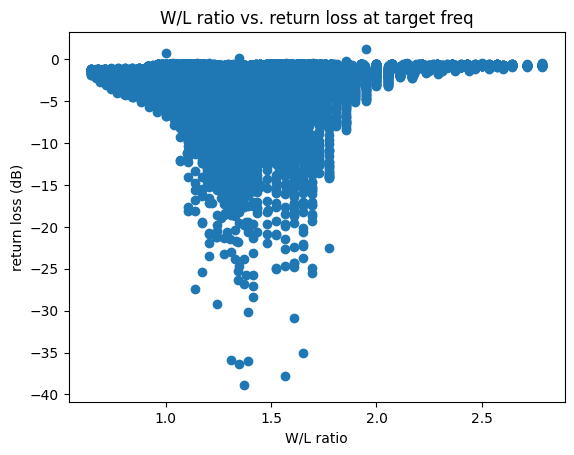

In [ ]:
# Frequency vs. return loss at target (dB)
plt.scatter(w/l, s11AtTarget)
plt.title("W/L ratio vs. return loss at target freq")
plt.xlabel("W/L ratio")
plt.ylabel("return loss (dB)")


Text(0, 0.5, 'max total gain (dB)')

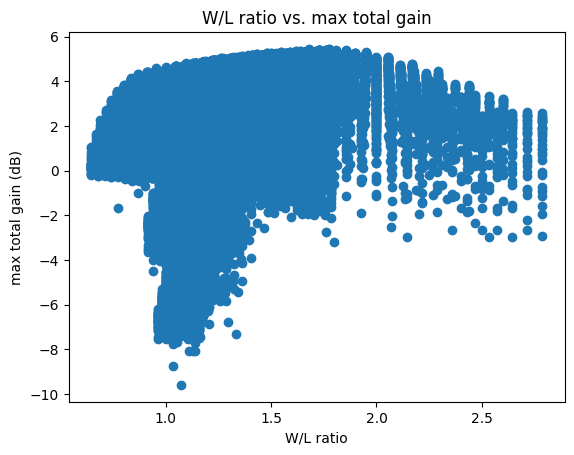

In [ ]:
# W/L vs. max total gain (dB)
plt.scatter(w/l, dBMaxGain)
plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("max total gain (dB)")


In [ ]:
# Frequency (classes labeled) vs. return loss at target (dB)

# get a unique list of the frequency values
UniqueNames = dataset.target_freq.unique()
print(UniqueNames)

[1500000000 2400000000 5800000000]


In [ ]:
# use the unique names to split up the data by frequency value
df1 = dataset[dataset['target_freq'] == 1500000000]
df2 = dataset[dataset['target_freq'] == 2400000000 ]
df3 = dataset[dataset['target_freq'] == 5800000000]

df1_w = df1['$width'].to_numpy()
df1_l = df1['$length'].to_numpy()
df1_s11 = df1['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df1_maxGain = df1['max_total_gain'].to_numpy()

df2_w = df2['$width'].to_numpy()
df2_l = df2['$length'].to_numpy()
df2_s11 = df2['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df2_maxGain = df2['max_total_gain'].to_numpy()

df3_w = df3['$width'].to_numpy()
df3_l = df3['$length'].to_numpy()
df3_s11 = df3['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df3_maxGain = df3['max_total_gain'].to_numpy()

# print the length of each dataset
print(len(df1))
print(len(df2))
print(len(df3))

10080
6158
10788


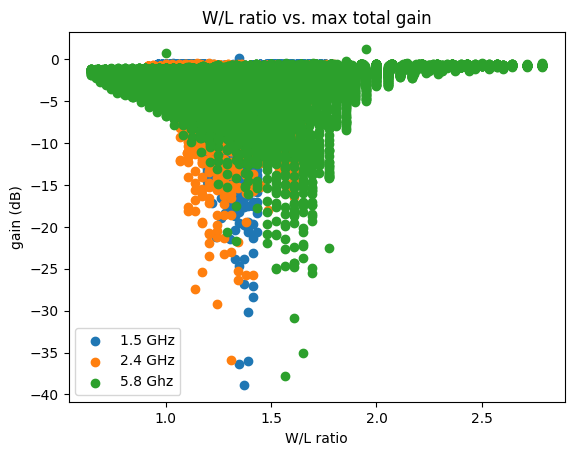

In [ ]:
# graph each class with a different color on the same plot
plt.scatter(df1_w/df1_l, df1_s11)
plt.scatter(df2_w/df2_l, df2_s11)
plt.scatter(df3_w/df3_l, df3_s11)

plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


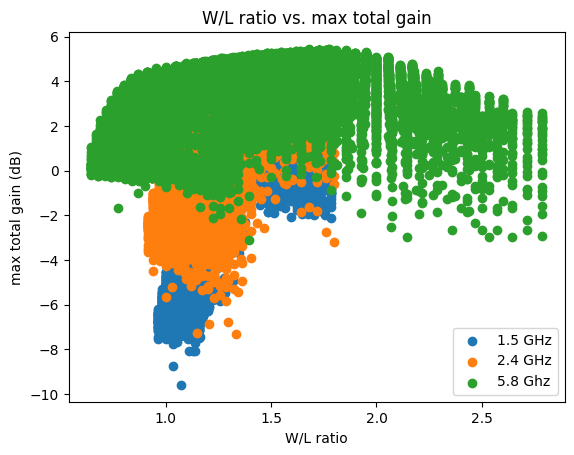

In [ ]:
# W/L (classes labeled) vs. max total gain (dB)
plt.scatter(df1_w/df1_l, df1_maxGain)
plt.scatter(df2_w/df2_l, df2_maxGain)
plt.scatter(df3_w/df3_l, df3_maxGain)
plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("max total gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


Simulations were run based on a parameter sweep, so not all simulations results in a valid design. The automated simulation process did not filter out invalid designs.

Below, two types of filters are applied as an example. The gain and return loss are used to remove a majority of the dataset. Without further filtering, it is not a guarantee that the remaining simulations are valid antenna designs (e.g., efficiency is not considered).

In [ ]:
# filtering the dataset to remove designs with poor gain

threshold_1500MHz = 2 #2dB minimum gain
threshold_2400MHz = 2 #2dB minimum gain
threshold_5800MHz = 3 #3dB minimum gain

returnLossdB = -10 #IEEE standard dB, 90% power transmission

# use the unique names to split up the data by frequency value
df1 = dataset[dataset['target_freq'] == 1500000000]
df2 = dataset[dataset['target_freq'] == 2400000000 ]
df3 = dataset[dataset['target_freq'] == 5800000000]

# use the threshold values to filter data by gain
df1_filtered = df1[df1['max_total_gain'] >= threshold_1500MHz]
df2_filtered = df2[df2['max_total_gain'] >= threshold_2400MHz ]
df3_filtered = df3[df3['max_total_gain'] >= threshold_5800MHz]

# use the threshold values to filter data by return loss
df1_filtered = df1_filtered[df1_filtered['s11_at_target'] <= returnLossdB]
df2_filtered = df2_filtered[df2_filtered['s11_at_target'] <= returnLossdB ]
df3_filtered = df3_filtered[df3_filtered['s11_at_target'] <= returnLossdB]

# print the length of the three dataframes
print(len(df1_filtered))
print(len(df2_filtered))
print(len(df3_filtered))

328
250
291


* Graphing filtered data:
  * Frequency (classes labeled) vs. return loss at target (dB)
  * W/L (classes labeled) vs. max total gain (dB)

In [ ]:
# use labels to set dataframe columns to variables
df1_w = df1_filtered['$width'].to_numpy()
df1_l = df1_filtered['$length'].to_numpy()
df1_s11 = df1_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df1_maxGain = df1_filtered['max_total_gain'].to_numpy()

df2_w = df2_filtered['$width'].to_numpy()
df2_l = df2_filtered['$length'].to_numpy()
df2_s11 = df2_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df2_maxGain = df2_filtered['max_total_gain'].to_numpy()

df3_w = df3_filtered['$width'].to_numpy()
df3_l = df3_filtered['$length'].to_numpy()
df3_s11 = df3_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df3_maxGain = df3_filtered['max_total_gain'].to_numpy()


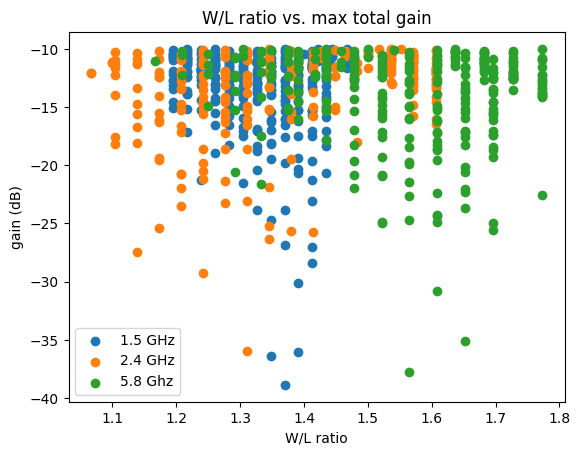

In [ ]:
# graph each class with a different color on the same plot
plt.scatter(df1_w/df1_l, df1_s11)
plt.scatter(df2_w/df2_l, df2_s11)
plt.scatter(df3_w/df3_l, df3_s11)

plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


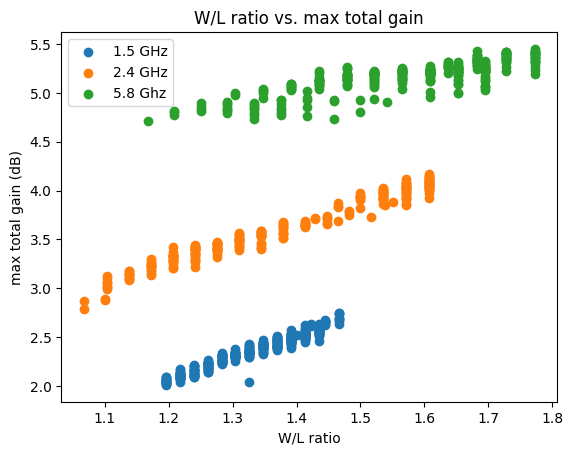

In [ ]:
# W/L (classes labeled) vs. max total gain (dB)
plt.scatter(df1_w/df1_l, df1_maxGain)
plt.scatter(df2_w/df2_l, df2_maxGain)
plt.scatter(df3_w/df3_l, df3_maxGain)
plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("max total gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])